In [15]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras import regularizers

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)

Python:  3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
pandas:  1.3.5
numpy:  1.21.6
seaborn:  0.11.2
matplotlib:  3.2.2
sklearn:  1.0.2
Keras:  2.8.0
Tensorflow:  2.8.2


In [16]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

In [17]:
df = pd.read_csv("/content/creditcard.csv", sep=",", index_col=None)
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [18]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [19]:
df[['Amount','Time']].agg(['min','max'])

,Amount,Time
min,0.00,0.0
max,25691.16,172792.0


In [20]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
#df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
#df.tail()
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])

Lets check number of anomalies/normal

In [21]:
anomalies = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

print(anomalies.shape, normal.shape)
print('anomalies: ',100*anomalies.shape[0]/(anomalies.shape[0]+normal.shape[0]),' %')

(400, 31) (20000, 31)
anomalies:  1.9607843137254901  %


Train, test split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1) , 
                                                    df['Class'], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(16320, 29) train samples
(4080, 29) test samples


Setup auto encoder

In [23]:
#simple autoencoder
logfilename = "simpleautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 12)                360       
                                                                 
 dense_1 (Dense)             (None, 29)                377       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


Other options/configurations to try later:

#sparse autoencoder
logfilename = "sparseautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu',
               activity_regularizer=regularizers.l1(10e-5))(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

#deep autoencoder
logfilename = "deepautoencoder"

encoding_dim = 16
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

In [24]:
autoencoder.compile(optimizer=RMSprop(), 
                    loss='mean_squared_error',
                    metrics=['mae', 'accuracy'])

Start the training

In [25]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='../logs/{0}'.format(logfilename))])

Epoch 1/20
510/510 [==============================] - 3s 3ms/step - loss: 1.4464 - mae: 0.6741 - accuracy: 0.3075 - val_loss: 1.5445 - val_mae: 0.6697 - val_accuracy: 0.4314
Epoch 2/20
510/510 [==============================] - 1s 2ms/step - loss: 1.3890 - mae: 0.6558 - accuracy: 0.5198 - val_loss: 1.5115 - val_mae: 0.6598 - val_accuracy: 0.5816
Epoch 3/20
510/510 [==============================] - 1s 2ms/step - loss: 1.3730 - mae: 0.6514 - accuracy: 0.6167 - val_loss: 1.5051 - val_mae: 0.6581 - val_accuracy: 0.6373
Epoch 4/20
510/510 [==============================] - 1s 2ms/step - loss: 1.3691 - mae: 0.6504 - accuracy: 0.6586 - val_loss: 1.5029 - val_mae: 0.6576 - val_accuracy: 0.6588
Epoch 5/20
510/510 [==============================] - 1s 2ms/step - loss: 1.3672 - mae: 0.6501 - accuracy: 0.6802 - val_loss: 1.5010 - val_mae: 0.6575 - val_accuracy: 0.6887
Epoch 6/20
510/510 [==============================] - 1s 2ms/step - loss: 1.3655 - mae: 0.6500 - accuracy: 0.7104 - val_loss: 1.49

In [26]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

128/128 [==============================] - 0s 3ms/step - loss: 1.4976 - mae: 0.6568 - accuracy: 0.7716
Test loss: 1.497580647468567
Test accuracy: 0.6568253040313721


In [27]:
threshold=15.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label=[]
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

In [28]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.55      0.60      0.58        93

    accuracy                           0.98      4080
   macro avg       0.77      0.80      0.78      4080
weighted avg       0.98      0.98      0.98      4080



In [29]:
roc_auc_score(y_test, y_label)

0.7954319279594164

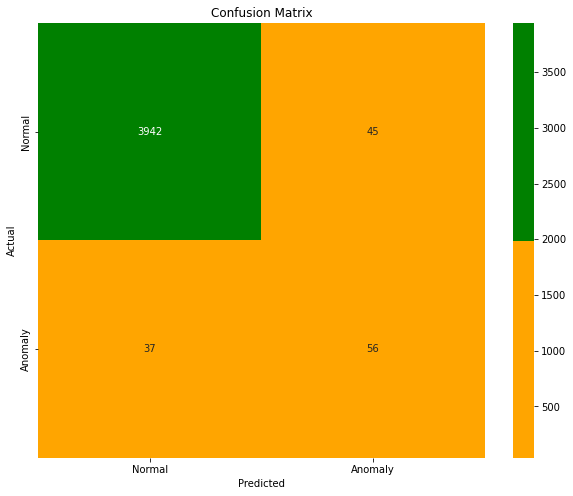

In [30]:
viz = Visualization()

viz.draw_confusion_matrix(y_test, y_label)

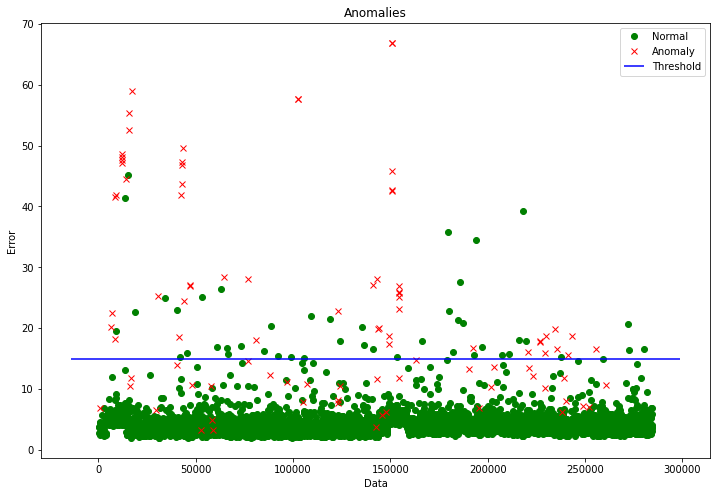

In [31]:
viz.draw_anomaly(y_test, error, threshold)